In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

# 1. LOAD DATA
# Ensure your file path is correct
df = pd.read_csv("C:/Users/megha/OneDrive/Desktop/project1/fin_audit/pay_sim.csv")

# 2. FORENSIC FEATURE ENGINEERING
# Fraudsters often manipulate balances. We calculate the "Balance Error"
df['errorBalanceOrg'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# Extract hour of day from 'step' (Forensic audit of time-based patterns)
df['hour'] = df['step'] % 24

# 3. DATA CLEANING
# Benford's Law and Isolation Forest work best on actual transaction types
# Filter for 'TRANSFER' and 'CASH_OUT' as they contain 99% of fraudulent activity
df_audit = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()

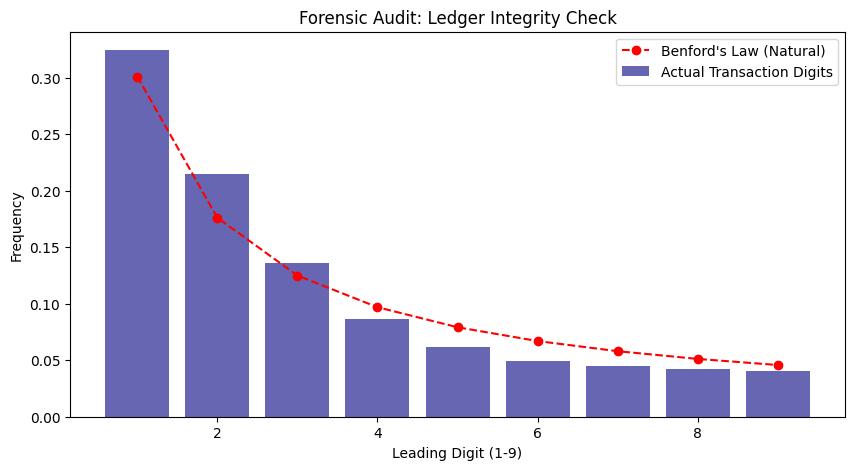

In [3]:
# Extract the first non-zero digit
df_audit = df_audit[df_audit['amount'] >= 1]
df_audit['first_digit'] = df_audit['amount'].astype(str).str[0].astype(int)

# Calculate observed vs expected distribution
observed = df_audit['first_digit'].value_counts(normalize=True).reindex(range(1, 10), fill_value=0)
expected = [np.log10(1 + 1/d) for d in range(1, 10)]

# Plotting the Forensic "Red Flag" Chart
plt.figure(figsize=(10, 5))
plt.bar(range(1, 10), observed, alpha=0.6, color='navy', label='Actual Transaction Digits')
plt.plot(range(1, 10), expected, marker='o', color='red', linestyle='--', label="Benford's Law (Natural)")
plt.xlabel('Leading Digit (1-9)')
plt.ylabel('Frequency')
plt.title("Forensic Audit: Ledger Integrity Check")
plt.legend()
plt.show()

In [4]:
# Prepare features for the model
le = LabelEncoder()
df_audit['type_enc'] = le.fit_transform(df_audit['type'])

# Select high-impact forensic features
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'errorBalanceOrg', 'hour', 'type_enc']
X = df_audit[features]

# Initialize Isolation Forest
# contamination=0.01 targets the top 1% most suspicious entries
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df_audit['anomaly_score'] = iso_forest.fit_predict(X)

# Anomaly score: -1 means "Isolated" (Suspicious), 1 means "Normal"
anomalies = df_audit[df_audit['anomaly_score'] == -1]

print(f"Forensic Audit Complete. Total Transactions Flagged for Review: {len(anomalies)}")

Forensic Audit Complete. Total Transactions Flagged for Review: 4590


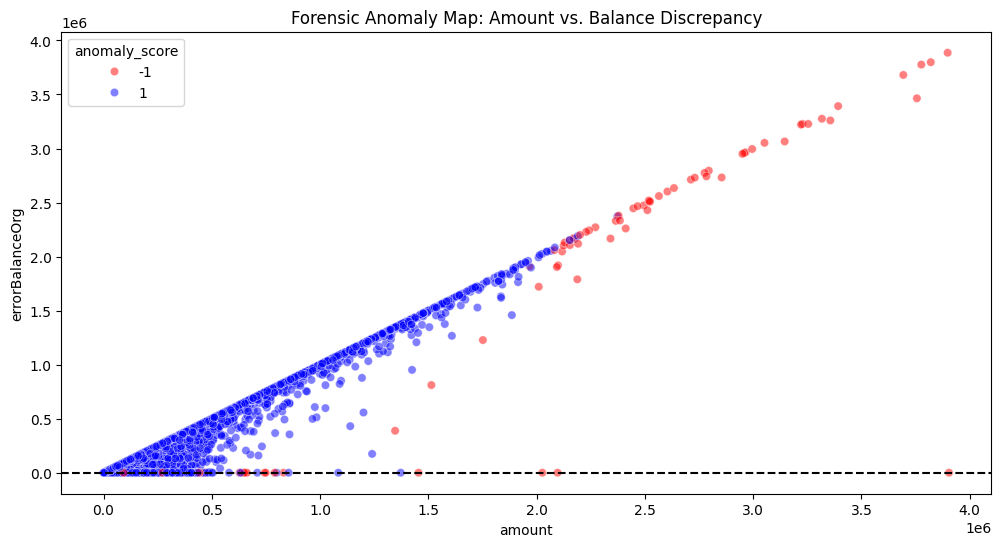

In [5]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_audit.sample(10000), x='amount', y='errorBalanceOrg', 
                hue='anomaly_score', palette={1: 'blue', -1: 'red'}, alpha=0.5)
plt.title("Forensic Anomaly Map: Amount vs. Balance Discrepancy")
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [6]:
import shap

# 1. Filter for the flagged anomalies from your Isolation Forest
anomaly_data = df_audit[df_audit['anomaly_score'] == -1]

# 2. Select a background sample for the explainer (baseline)
# This represents what 'normal' behavior looks like
X_background = X.sample(100, random_state=42)

# 3. Select a specific anomaly to explain (e.g., the first one in your list)
X_to_explain = anomalies[features].iloc[:1]

# 4. Initialize the Explainer
# We use the decision_function of the Isolation Forest as the target
explainer = shap.KernelExplainer(iso_forest.decision_function, X_background)

# 5. Calculate SHAP values for the specific anomaly
shap_values = explainer.shap_values(X_to_explain)

# 6. Visualize the 'Reasoning' for the Anomaly
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_to_explain)

  0%|          | 0/1 [00:00<?, ?it/s]

 96%|=================== | 4429/4590 [00:24<00:00]       

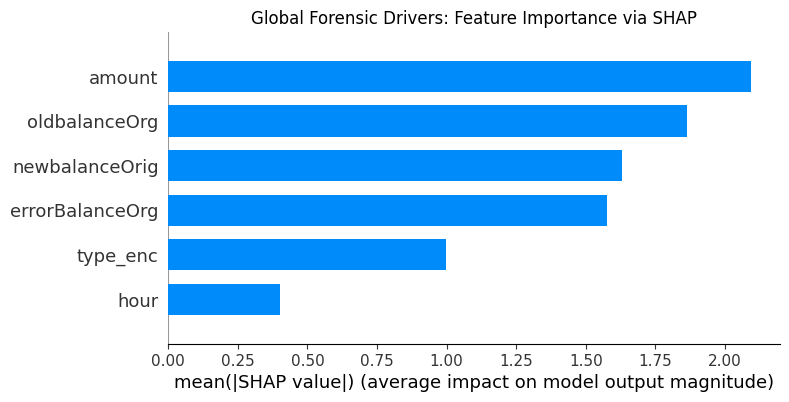

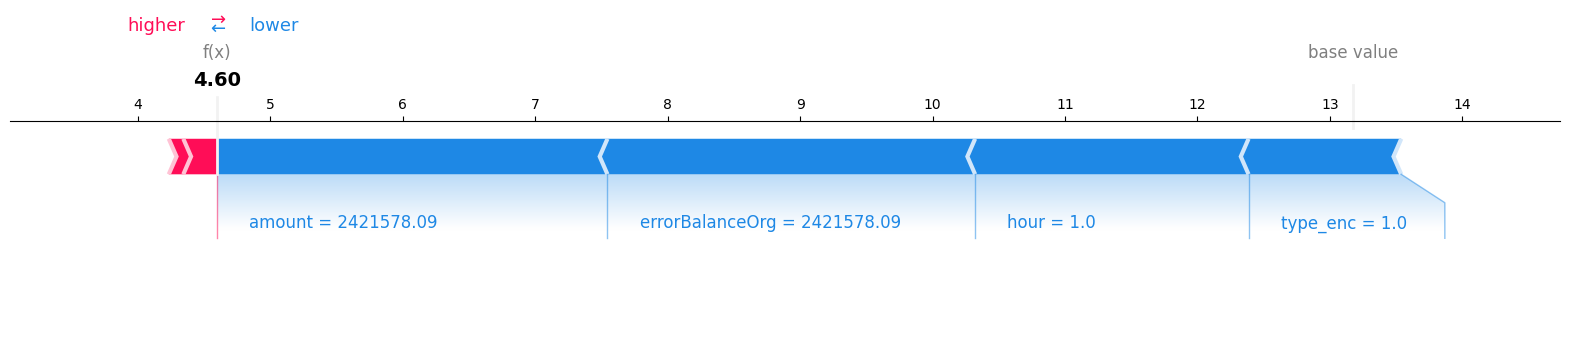

In [7]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the Explainer
# We use a TreeExplainer for high-performance with Isolation Forest
# We pass a background sample of 100 'normal' transactions to establish a baseline
explainer = shap.TreeExplainer(iso_forest, data=X.sample(100, random_state=42))

# 2. Strategic Sampling for Explainability
# Analyzing all 6M rows is redundant. We explain the 'Anomalies' only.
# This mimics a real forensic audit where an investigator asks: "Explain these 4,590 flags."
X_anomalies = X[df_audit['anomaly_score'] == -1]
shap_values = explainer.shap_values(X_anomalies)

# 3. GLOBAL ANALYSIS: Feature Importance
# This plot tells the auditor which features are the biggest "Fraud Drivers" globally.
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_anomalies, plot_type="bar", show=False)
plt.title("Global Forensic Drivers: Feature Importance via SHAP")
plt.show()

# 4. LOCAL ANALYSIS: Explaining a Single "Red Flag" Transaction
# Let's pick the most extreme anomaly (lowest score) to visualize its "Reason Code"
extreme_anomaly_idx = df_audit['anomaly_score'].idxmin()
X_instance = X.loc[[extreme_anomaly_idx]]
shap_instance_values = explainer.shap_values(X_instance)

# Force Plot: Visualizing the "Push and Pull" of features for this specific audit entry
shap.initjs()
shap.force_plot(
    explainer.expected_value, 
    shap_instance_values[0], 
    X_instance,
    matplotlib=True # Set to True for static plot in Jupyter
)

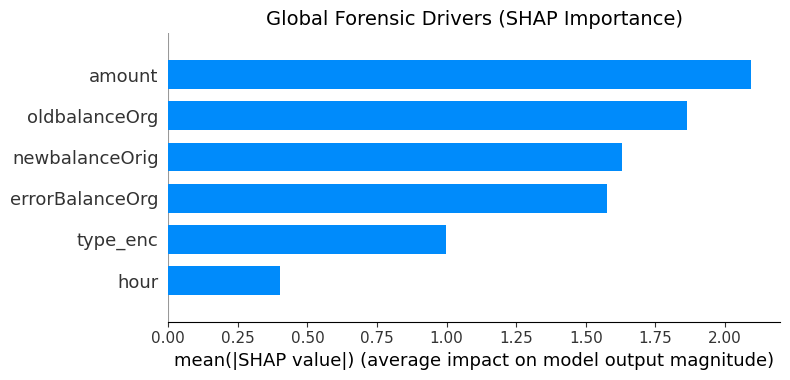

In [8]:
# 1. Global Summary Bar Plot
plt.figure(figsize=(10, 6))
# This shows the mean absolute SHAP value for each feature
shap.summary_plot(shap_values, X_anomalies, plot_type="bar", show=False)
plt.title("Global Forensic Drivers (SHAP Importance)", fontsize=14)
plt.tight_layout()
plt.savefig('shap_summary_plot.png')
plt.show()

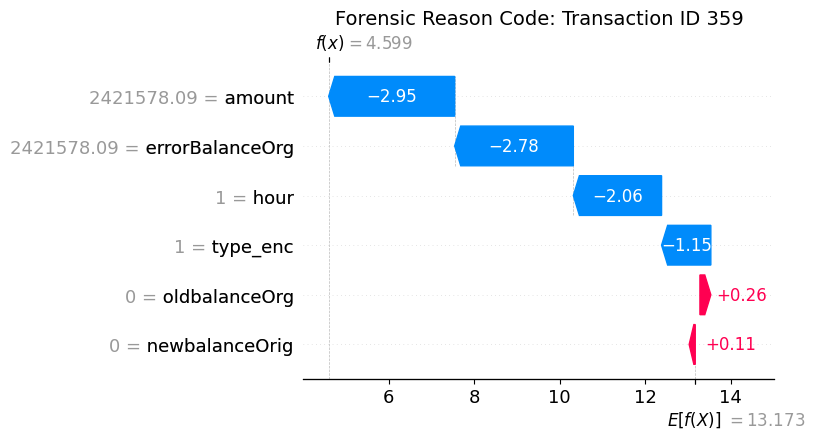

In [9]:
# 2. Local Waterfall Plot for the most extreme anomaly
# We use the TreeExplainer's shap_values for a single instance
extreme_idx = 0 # Selecting the first anomaly in the list
# Create an Explanation object for the waterfall plot
explr_obj = shap.Explanation(values=shap_values[extreme_idx], 
                             base_values=explainer.expected_value, 
                             data=X_anomalies.iloc[extreme_idx], 
                             feature_names=features)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(explr_obj, show=False)
plt.title(f"Forensic Reason Code: Transaction ID {X_anomalies.index[extreme_idx]}", fontsize=14)
plt.tight_layout()
plt.savefig('shap_waterfall_plot.png')
plt.show()

In [ ]:
# 1. Sort by Origin Account and Time (step)
df_audit = df_audit.sort_values(['nameOrig', 'step'])

# 2. Calculate Transaction Velocity
# This counts how many times an account appears in the last 3 'steps' (time units)
df_audit['tx_velocity'] = df_audit.groupby('nameOrig')['amount'].transform(lambda x: x.rolling(window=3).count())

# 3. Calculate Cumulative Amount Velocity
# This sums the total money moved by an account in the last 3 steps
df_audit['amount_velocity'] = df_audit.groupby('nameOrig')['amount'].transform(lambda x: x.rolling(window=3).sum())

# Fill NaNs resulting from rolling windows
df_audit[['tx_velocity', 'amount_velocity']] = df_audit[['tx_velocity', 'amount_velocity']].fillna(0)

In [ ]:
# 1. Extract the last integer digit of the amount
# We use modulo 10 to get the digit in the 'ones' place
df_audit['last_digit'] = df_audit['amount'].astype(int) % 10

# 2. Calculate the distribution
last_digit_dist = df_audit['last_digit'].value_counts(normalize=True).sort_index()

# 3. Visualization for the Audit Report
plt.figure(figsize=(10, 5))
plt.bar(range(10), last_digit_dist, color='teal', alpha=0.7)
plt.axhline(y=0.1, color='red', linestyle='--', label='Uniform Distribution (Expected)')
plt.xticks(range(10))
plt.title("Forensic Audit: Last-Digit Preference Analysis")
plt.xlabel("Last Digit (0-9)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
# Update the feature list to include Velocity and Time-based features
advanced_features = ['amount', 'errorBalanceOrg', 'hour', 'tx_velocity', 'amount_velocity', 'type_enc']
X_adv = df_audit[advanced_features]

# Re-train the model
iso_forest_adv = IsolationForest(contamination=0.01, random_state=42)
df_audit['anomaly_score_adv'] = iso_forest_adv.fit_predict(X_adv)

print(f"Advanced Audit Complete. New Anomaly Count: {len(df_audit[df_audit['anomaly_score_adv'] == -1])}")